# <center>_Toxic Comment Detection_</center>

## _Loading Data_

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("labeled.csv", sep=",")
df['toxic'] = df['toxic'].apply(int)

___

## _EDA_

In [3]:
df.shape

(14412, 2)

In [4]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [5]:
df.query('toxic == 1')['comment']

0                     Верблюдов-то за что? Дебилы, бл...\n
1        Хохлы, это отдушина затюканого россиянина, мол...
2                                Собаке - собачья смерть\n
3        Страницу обнови, дебил. Это тоже не оскорблени...
4        тебя не убедил 6-страничный пдф в том, что Скр...
                               ...                        
14404    ЖЕНЩИНА это ВЕНЕЦ ТВОРЕНИЯ, помните это ваньки...
14405    Сейчас все авиакомпании мира вместе со специал...
14407    Вонючий совковый скот прибежал и ноет. А вот и...
14408    А кого любить? Гоблина тупорылого что-ли? Или ...
14410    КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...
Name: comment, Length: 4826, dtype: object

In [6]:
df.query('toxic == 0')['comment']

6        В шапке были ссылки на инфу по текущему фильму...
12       Почитайте посты у этого автора,может найдете ч...
17       Про графику было обидно) я так то проходил все...
28       https: pp.userapi.com c848520 v848520411 11627...
35       Возьмём как пример Россию, западноевропейские ...
                               ...                        
14392    ТАСС, 21 марта. Премьер-министр Новой Зеландии...
14399    65 А чего так мало? Вот у гражданина был рейти...
14406    Потому что запад прошел эту хуйню еще пару сот...
14409    Посмотрел Утомленных солнцем 2. И оказалось, ч...
14411    До сих пор пересматриваю его видео. Орамбо кст...
Name: comment, Length: 9586, dtype: object

In [7]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
# nltk.download('punkt')
# nltk.download('stopwords')

stemmer = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool=True):
    """Преобразует предложения в токены.
    По шагам:
    1) Токенизация - разбиение текста на отдельные слова и знаки пунктуации
    2) Удаляем знаки пунктуации
    3) Удаляем стоп-слова (часто используемые, не несущие смысловой нагрузки)
    4) Стемминг (stem - корень) - удаление окончаний и приведение к нижнему регистру
    """
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [stemmer.stem(i) for i in tokens]
    return tokens

In [8]:
example = df.loc[1]['comment']
example

'Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n'

In [9]:
tokenize_sentence(example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True), 
                             token_pattern=None)

In [120]:
from sklearn.model_selection import train_test_split

features, labels = df['comment'], df['toxic']
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=0)

___

## _Testing Different Models_

In [112]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [113]:
models = {'kNN': KNeighborsClassifier(),
          'LogisticRegression': LogisticRegression(),
          'DecisionTree': DecisionTreeClassifier(), 
          'SGDClassifier': SGDClassifier(loss='log_loss')}

In [121]:
from sklearn.pipeline import Pipeline

def models_report(models, x_train, x_test, y_train, y_test):
    report = pd.DataFrame()
    for model in models:
        model_pipeline = Pipeline([('vectorizer', vectorizer), 
                                   ('model', models[model])])
        model_pipeline.fit(x_train, y_train)
        y_pred = model_pipeline.predict(x_test)
        report.loc[model, 'Precision'] = precision_score(y_test, y_pred)
        report.loc[model, 'Recall'] = recall_score(y_test, y_pred)
        report.loc[model, 'ROC-AUC'] = roc_auc_score(y_test, y_pred)
    return report

In [122]:
models_report(models, x_train, x_test, y_train, y_test)

,Precision,Recall,ROC-AUC
kNN,0.820724,0.517098,0.730134
LogisticRegression,0.914504,0.620725,0.795764
DecisionTree,0.694479,0.586528,0.728353
SGDClassifier,0.917591,0.600000,0.786444


___

## _kNN_

In [16]:
from sklearn.model_selection import GridSearchCV

knn_grid = GridSearchCV(KNeighborsClassifier(), 
                        param_grid={'n_neighbors': range(10, 21)}, 
                        cv=3)
knn_grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(10, 21)})

In [17]:
print(f'best params: {knn_grid.best_params_}')
print(f'best score: {knn_grid.best_score_}')

y_pred_knn_best = knn_grid.predict(x_test)
knn_precision_best = precision_score(y_test, y_pred_knn_best)
knn_recall_best = recall_score(y_test, y_pred_knn_best)
knn_roc_auc_best = roc_auc_score(y_test, y_pred_knn_best)
print(f'AFTER Cross-validation')
print(f'Precision: {knn_precision_best}\nRecall: {knn_recall_best}\nROC-AUC: {knn_roc_auc_best}')
# print('-------------------------------------------------')
# print(classification_report(y_test, y_pred_knn_best))

best params: {'n_neighbors': 11}
best score: 0.8240090207303322
AFTER Cross-validation
Precision: 0.864696734059098
Recall: 0.5761658031088083
ROC-AUC: 0.7654030266847484


___

## _Logistic Regression_

In [18]:
# from sklearn.linear_model import LogisticRegressionCV

# cs = np.logspace(-1, 2, 100)
# log_reg_cv = LogisticRegressionCV(Cs=cs, 
#                                   cv=3, 
#                                   verbose=0, 
#                                   max_iter=300)
# log_reg_cv.fit(x_train, y_train)

# print(f'best C: {log_reg_cv.C_}')

# y_pred_lr_best = log_reg_cv.predict(x_test)

# lr_precision_best = precision_score(y_test, y_pred_lr_best)
# lr_recall_best = recall_score(y_test, y_pred_lr_best)
# lr_roc_auc_best = roc_auc_score(y_test, y_pred_lr_best)
# print(f'AFTER Cross-validation')
# print(f'Precision: {lr_precision_best}\nRecall: {lr_recall_best}\nROC-AUC: {lr_roc_auc_best}')
# print('-------------------------------------------------')
# print(classification_report(y_test, y_pred_lr_best))

In [61]:
lr_grid = GridSearchCV(LogisticRegression(max_iter=300), 
                       param_grid={'C': np.logspace(-1, 2, 30)},
                       cv=3)
lr_grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=300),
             param_grid={'C': array([  0.1       ,   0.1268961 ,   0.1610262 ,   0.20433597,
         0.25929438,   0.32903446,   0.41753189,   0.52983169,
         0.67233575,   0.85316785,   1.08263673,   1.3738238 ,
         1.74332882,   2.21221629,   2.8072162 ,   3.56224789,
         4.52035366,   5.73615251,   7.27895384,   9.23670857,
        11.72102298,  14.87352107,  18.87391822,  23.9502662 ,
        30.39195382,  38.56620421,  48.93900918,  62.10169419,
        78.80462816, 100.        ])})

In [62]:
print(f'best params: {lr_grid.best_params_}')
print(f'best score: {lr_grid.best_score_}')

y_pred_lr_best = lr_grid.predict(x_test)
lr_precision_best = precision_score(y_test, y_pred_lr_best)
lr_recall_best = recall_score(y_test, y_pred_lr_best)
lr_roc_auc_best = roc_auc_score(y_test, y_pred_lr_best)
print(f'AFTER Cross-validation')
print(f'Precision: {lr_precision_best}\nRecall: {lr_recall_best}\nROC-AUC: {lr_roc_auc_best}')
# print('-------------------------------------------------')
# print(classification_report(y_test, y_pred_knn_best))

best params: {'C': 23.95026619987486}
best score: 0.8604388932257785
AFTER Cross-validation
Precision: 0.8580246913580247
Recall: 0.7202072538860104
ROC-AUC: 0.8301244820003566


In [21]:
from sklearn.metrics import precision_recall_curve

pr, rc, ths = precision_recall_curve(y_true=y_test, 
                                     probas_pred=lr_grid.predict_proba(x_test)[:,1])

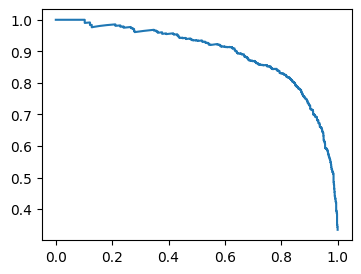

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(4, 3))
plt.plot(rc, pr)

In [23]:
pr_index = np.where(pr > 0.95)[0][0]
threshold = ths[pr_index].round(4)
probas = (lr_grid.predict_proba(x_test)[:,1] > threshold)
print(f'Precision: {precision_score(y_test, probas)}')
print(f'   Recall: {recall_score(y_test, probas)}')

Precision: 0.9501133786848073
   Recall: 0.43419689119170984


In [24]:
threshold

0.8663

___

## _Gradient Descent_

In [65]:
sgd_grid = GridSearchCV(SGDClassifier(loss='log_loss', early_stopping=True, validation_fraction=0.2, random_state=0), 
                        param_grid={'learning_rate': ['optimal'], 
                                    'alpha' : [0.00023, 0.001, 0.01]}, 
                        cv=5)
sgd_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(early_stopping=True, loss='log_loss',
                                     random_state=0, validation_fraction=0.2),
             param_grid={'alpha': [0.00023, 0.001, 0.01],
                         'learning_rate': ['optimal']})

In [66]:
print(f'best params: {sgd_grid.best_params_}')
print(f'best score: {sgd_grid.best_score_}')

y_pred_sgd_best = sgd_grid.predict(x_test)
sgd_precision_best = precision_score(y_test, y_pred_sgd_best)
sgd_recall_best = recall_score(y_test, y_pred_sgd_best)
sgd_roc_auc_best = roc_auc_score(y_test, y_pred_sgd_best)
print(f'AFTER Cross-validation')
print(f'Precision: {sgd_precision_best}\nRecall: {sgd_recall_best}\nROC-AUC: {sgd_roc_auc_best}')

best params: {'alpha': 0.00023, 'learning_rate': 'optimal'}
best score: 0.7991152383765447
AFTER Cross-validation
Precision: 0.9506437768240343
Recall: 0.45906735751295336
ROC-AUC: 0.723537849767947


In [27]:
from sklearn.pipeline import Pipeline

sgd_best_pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))), 
                          ('model', SGDClassifier(loss='log_loss', 
                                                  alpha=0.00023, 
                                                  early_stopping=True, 
                                                  validation_fraction=0.2, 
                                                  random_state=0))])
# sgd_best_pipe.fit(x_train, y_train)
# sgd_best_pipe.predict(...)

___!!! Тут надо еще поработать !!!___

___

## _Decision Tree_

___

## _Random Forest_

___